# Initialization

In [1]:
from qiskit import QuantumCircuit, transpile, QuantumRegister
from qiskit_aer import AerSimulator, QasmSimulator, Aer
# from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler, Estimator, Options
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Options
from qiskit_ibm_runtime import Sampler, SamplerV2
from qiskit.visualization import plot_histogram

from datetime import datetime
import mysql.connector
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import re
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)
import json

from qiskit_ibm_runtime.fake_provider import fake_backend

import copy
from qiskit.visualization import plot_histogram, plot_state_city
import qiskit.quantum_info as qi
from qiskit.qasm2 import dumps
from qiskit.visualization import plot_circuit_layout
 
from qiskit.circuit.library import RZZGate, RZGate, XGate, IGate
from qiskit.converters import circuit_to_dag, dag_to_circuit

from qiskit.transpiler.passes import ALAPScheduleAnalysis, ASAPScheduleAnalysis, PadDynamicalDecoupling, PadDelay
from qiskit.transpiler import PassManager
import numpy as np
from qiskit.qasm2 import dumps

import mthree
import stim

CB_color_cycle = [
    '#006BA4',  # Blue
    '#FF800E',  # Orange
    '#ABABAB',  # Gray
    '#595959',  # Dark Gray
    '#5F9ED1',  # Light Blue
    '#C85200',  # Dark Orange
    '#898989',  # Medium Gray
    '#A2C8EC',  # Pale Blue
    '#FFBC79',  # Light Orange
    '#CFCFCF',  # Light Gray
    '#009E73',  # Green (Colorblind-friendly)
    '#F0E442'   # Yellow (Colorblind-friendly)
]

markers = ['o', 'v', '^', 's', '+', '*', 'x', 'd', '<', '>', 'p']
linestyles = ['-', '--', '-.', ':', '-', '--', '-.', ':']

# MySQL connection parameters
mysql_config = {
    'user': 'handy',
    'password': 'handy',
    'host': 'localhost',
    'database': 'framework'
}

shots = 4000

mysql_config_online = {
    'user': 'handy',
    'password': 'handy',
    'host': 'ec2-16-171-135-24.eu-north-1.compute.amazonaws.com',
    'database': 'calibration_data'
}





In [2]:
import os
import sys

#module_path = os.path.abspath(os.path.join('..', 'functions'))
#if module_path not in sys.path:
#    sys.path.append(module_path)

from commons import (
    used_qubits, sum_middle_digits_dict
)

from commons import (Config, convert_utc_to_local, calculate_time_diff, get_count_1q, get_count_2q, 
    calculate_circuit_cost, get_correct_output_dict, calculate_success_rate_nassc, calculate_success_rate_tvd, 
    calculate_success_rate_polar, calculate_hellinger_distance, calculate_success_rate_tvd_new, 
    convert_to_json, is_mitigated, get_initial_mapping_json, normalize_counts, convert_dict_int_to_binary, reverse_string_keys, convert_dict_binary_to_int,
    sum_middle_digits_dict
)

from wrappers.multiprogramming_wrapper import (
    avoid_simultaneous_cnot, add_zz_on_simultaneous_cnot, 
    build_idle_coupling_map, multiprogram_compilation_qiskit, merge_circuits,
    get_LF_presets_cm
)
from wrappers.polar_wrapper import (
        polar_code_p2, get_logical_error_on_accepted_states, get_q1prep_sr, get_i_position, make_polar_qc_based_p2,
divide_half_list
)

from wrappers.prune_wrapper import (
    create_full_graph, generate_figures, generate_node_errors, generate_edge_errors,
    get_latest_calibration_id, get_edges_threshold, get_readout_threshold, get_LF_qubits
)

from wrappers.dd_wrapper import (
    convert_dt_to_us, count_delay_durations, apply_pad_delay, get_delay_information, get_dd_information, 
    get_delay_and_dd_information_us
)

from wrappers.qiskit_wrapper import (
    apply_dd, get_zz_rates_from_backend_in_hz, get_qubits_T1_T2, get_gates_length, generate_errors_thermal_relaxation, 
generate_thermal_noise_model_on_used_qubits, get_neighbor_zz_rates_by_qubit, create_rzz_operator,
replace_delay_with_rzz
)

In [3]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService
 
# token = "476ea8c61cc54f36e4a21d70a8442f94203c9d87096eaad0886a3e8154d8c2e79bcad6f927c6050a76335dd68d783f478c1b828504748a4377b441c335c831aa"
token = "04ede7f82299b792eae4daf3581f62415b3af676370f752f52d40e5851c7201d6e357c36e7bd55e4719c80d66bba7474412253f6c62f0ea7577bf056aa92eb62"
QiskitRuntimeService.save_account(channel="ibm_quantum", token=token, overwrite=True)
service = QiskitRuntimeService(channel="ibm_quantum", token=token)

#hw_name = "ibm_kyiv"
hw_name = "ibm_sherbrooke"
backend = service.backend(hw_name)

sim_ideal = AerSimulator()
sim_noisy = AerSimulator.from_backend(backend)

## change later back to 3
pm = generate_preset_pass_manager(
    optimization_level=3, backend=backend
)

## Azure

In [4]:
from azure.quantum import Workspace
from azure.quantum.qiskit import AzureQuantumProvider

# Replace with your workspace info
workspace = Workspace(
            resource_id = "/subscriptions/b702561e-9272-4626-8d8a-53deba1b43fb/resourceGroups/AzureQuantum/providers/Microsoft.Quantum/Workspaces/HandyQuantum",
            location = "eastus")

provider_azure = AzureQuantumProvider(workspace)
# List available backends
provider_azure.backends()



[<IonQSimulatorQirBackend('ionq.simulator')>,
 <IonQAriaQirBackend('ionq.qpu.aria-1')>,
 <IonQAriaQirBackend('ionq.qpu.aria-2')>,
 <QuantinuumSyntaxCheckerQirBackend('quantinuum.sim.h1-1sc')>,
 <QuantinuumEmulatorQirBackend('quantinuum.sim.h1-1e')>,
 <QuantinuumQPUQirBackend('quantinuum.qpu.h1-1')>,
 <RigettiSimulatorBackend('rigetti.sim.qvm')>,
 <RigettiQPUBackend('rigetti.qpu.ankaa-3')>]

In [5]:
print("This workspace's targets:")
for backend in provider_azure.backends():
    print("- " + backend.name())

This workspace's targets:
- ionq.simulator
- ionq.qpu.aria-1
- ionq.qpu.aria-2
- quantinuum.sim.h1-1sc
- quantinuum.sim.h1-1e
- quantinuum.qpu.h1-1
- rigetti.sim.qvm
- rigetti.qpu.ankaa-3


### Check Object

In [6]:
print(dir(provider_azure))

['__abstractmethods__', '__annotations__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__firstlineno__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__static_attributes__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_backend_names', '_backends', '_filter_backends', '_get_allowed_targets_from_workspace', '_get_backend_instance', '_get_candidate_subclasses', '_has_config_value', '_init_backends', '_is_available_in_ws', '_match_all', '_match_azure_config', '_match_config', '_workspace', 'backends', 'get_backend', 'get_job', 'get_workspace', 'version']


In [7]:
job_id = "d41dd9c2-6237-11ef-9c05-00155db34f42"
job = provider_azure.get_job(job_id)
job

In [8]:
result = job.result()

In [9]:
counts = result.get_counts()
sum(counts.values())

10000

In [10]:
n = 3
lstate = "X"
get_logical_error_on_accepted_states(n, lstate, counts)

(9330, 3616, 6756, 0.6124330117899249, 0.3663929200010898, 0.1346666079989518)

In [11]:
#backend_h1 = provider.get_backend("quantinuum.sim.h1-1e")
backend_h1 = provider.get_backend("quantinuum.qpu.h1-1")


NameError: name 'provider' is not defined

In [ ]:
print(dir(backend_h1))

In [ ]:
conf = backend_h1.configuration()
conf

In [ ]:
print(dir(conf))

In [ ]:
conf_dict = conf.to_dict()
print(conf_dict)

In [ ]:
prop = backend_h1.properties()
print(prop)


In [109]:
backend_h1.status()

### Run in Azure Quantinuum

Job id: 10c47761-269f-11f0-9f94-fbcc28f08e20
.........

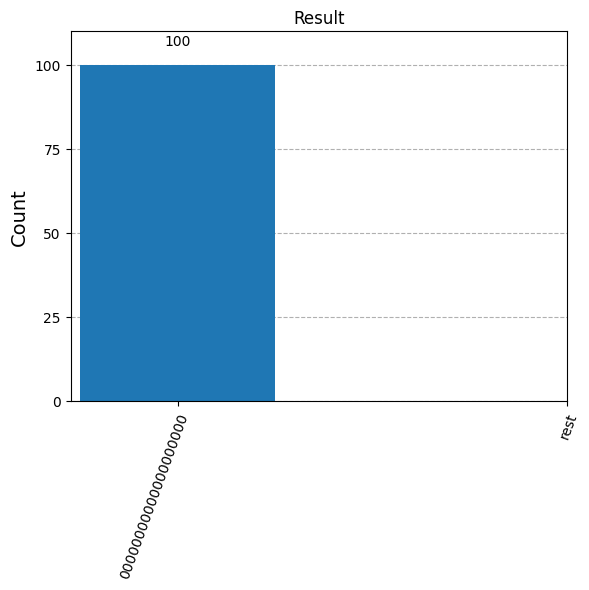

In [111]:
quantinuum_api_val_backend = provider.get_backend("quantinuum.sim.h1-1sc")
job = quantinuum_api_val_backend.run(polar_n3_x, shots=100)
print("Job id:", job.id())

result = job.result()

# The result object is native to the Qiskit package, so we can use Qiskit's tools to print the result as a histogram.
# For the syntax check, we expect to see all zeroes.
plot_histogram(result.get_counts(polar_n3_x), title="Result", number_to_keep=2)


# Polar Code - with Dynamic Circuit

n = 3 , b = 010 (2) , i = 3


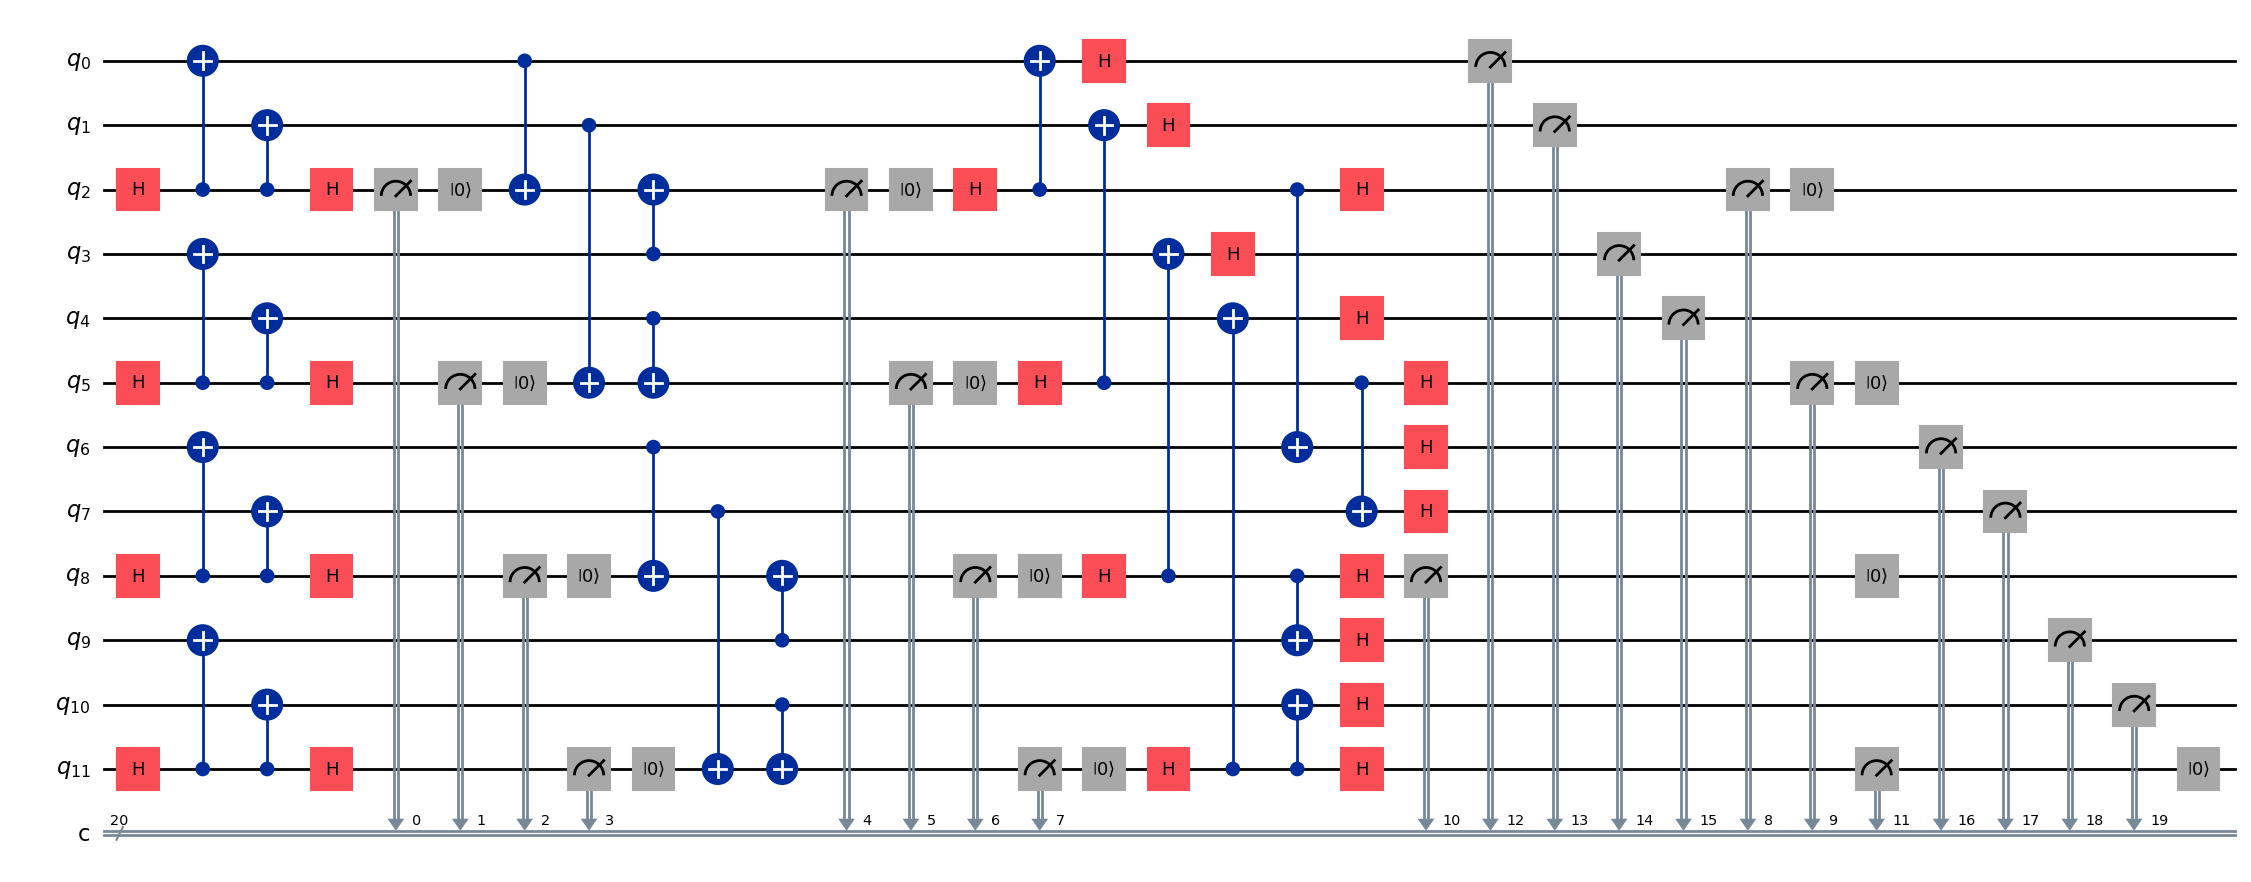

In [152]:
polar_n3_x_meas_data = polar_code_p2(3, True, "x", False)
polar_n3_x_meas_data.draw("mpl", fold=-1)

In [172]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

def extract_z_syndrome(circuit, target, controls, measure):
    circuit.cx(controls[0], target)
    circuit.cx(controls[1], target)
    circuit.measure(target, measure)

    with circuit.if_test((measure, True)):
        circuit.x(controls[0])

    circuit.reset(target)

## n=3 logical |+>

In [228]:
dag = circuit_to_dag(polar_n3_x_meas_data)

qreg = QuantumRegister(12, name="q")
creg = ClassicalRegister(20, name="c")
mid_measure = ClassicalRegister(4, name="mid")
new_circuit = QuantumCircuit(qreg, creg, mid_measure)
for idx, layer in enumerate(dag.layers()):
    layer_as_circuit = dag_to_circuit(layer['graph'])

    new_circuit = new_circuit.compose(layer_as_circuit)

    if idx == 9:
        for m_idx, i in enumerate(range(0, 11, 3)):
            controls = [i, i+1]
            target = i + 2
            measure = mid_measure[m_idx]
        
            extract_z_syndrome(new_circuit, target, controls, measure)
            
            #if m_idx in [0,1]:
            #    binary_0 = 1 << 0 + 4 # 00010000
            #    binary_1 = 1 << 1 + 4 # 00100000
            #    with new_circuit.if_test((creg, binary_0)):
            #        extract_z_syndrome(new_circuit, target, controls, measure)
        
            #    with new_circuit.if_test((creg, binary_1)):
            #        extract_z_syndrome(new_circuit, target, controls, measure)
            #else:
            #    binary_0 = 1 << 2 + 4 # 01000000
            #    binary_1 = 1 << 3 + 4 # 10000000
            #    with new_circuit.if_test((creg, binary_0)):
            #        extract_z_syndrome(new_circuit, target, controls, measure)
        
             #   with new_circuit.if_test((creg, binary_1)):
             #       extract_z_syndrome(new_circuit, target, controls, measure)



/tmp/ipykernel_13549/833463805.py:8: DeprecationWarning: The property ``qiskit.dagcircuit.dagcircuit.DAGCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  layer_as_circuit = dag_to_circuit(layer['graph'])
/tmp/ipykernel_13549/833463805.py:8: DeprecationWarning: The property ``qiskit.dagcircuit.dagcircuit.DAGCircuit.unit`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  layer_as_circuit = dag_to_circuit(layer['graph'])


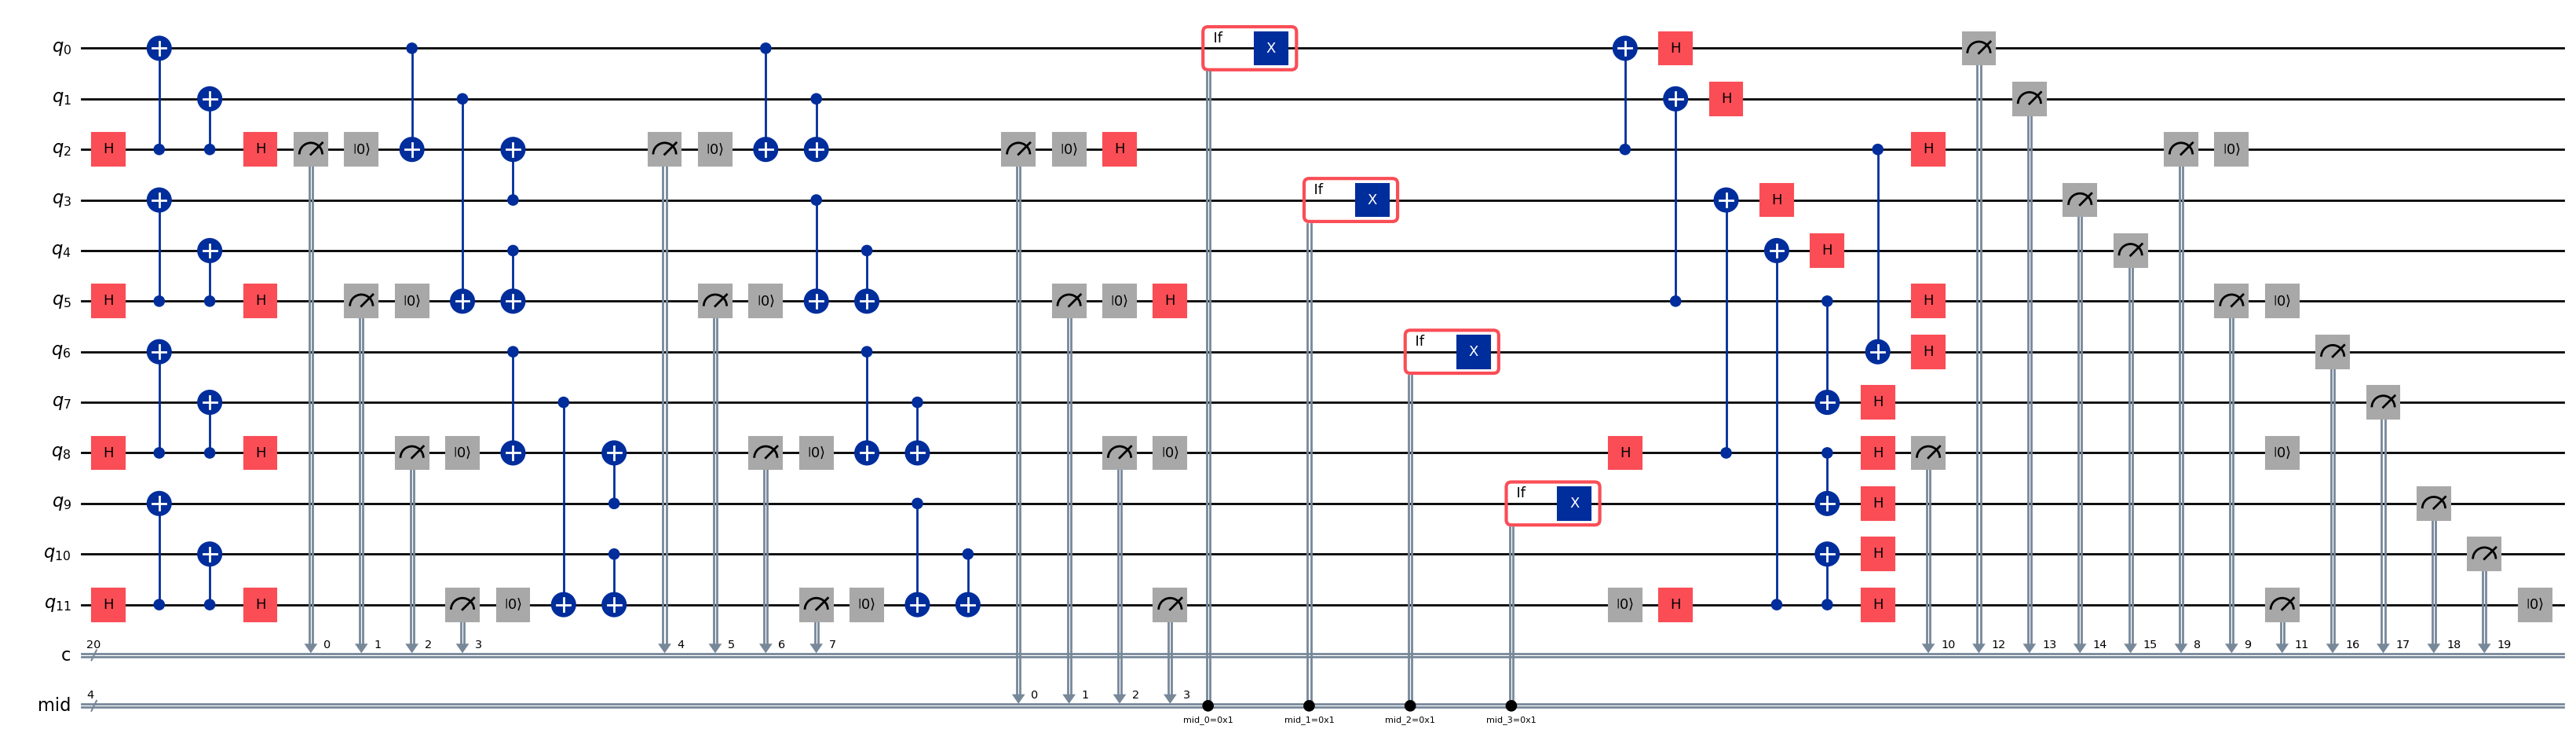

In [174]:
new_circuit.draw("mpl", fold=-1)

In [ ]:
n = 3
lstate = "X"
shots = 3000

tqc = pm.run(polar_n3_x_meas_data)

OrderedDict({'rz': 220, 'sx': 128, 'ecr': 52, 'measure': 20, 'reset': 12, 'x': 6})


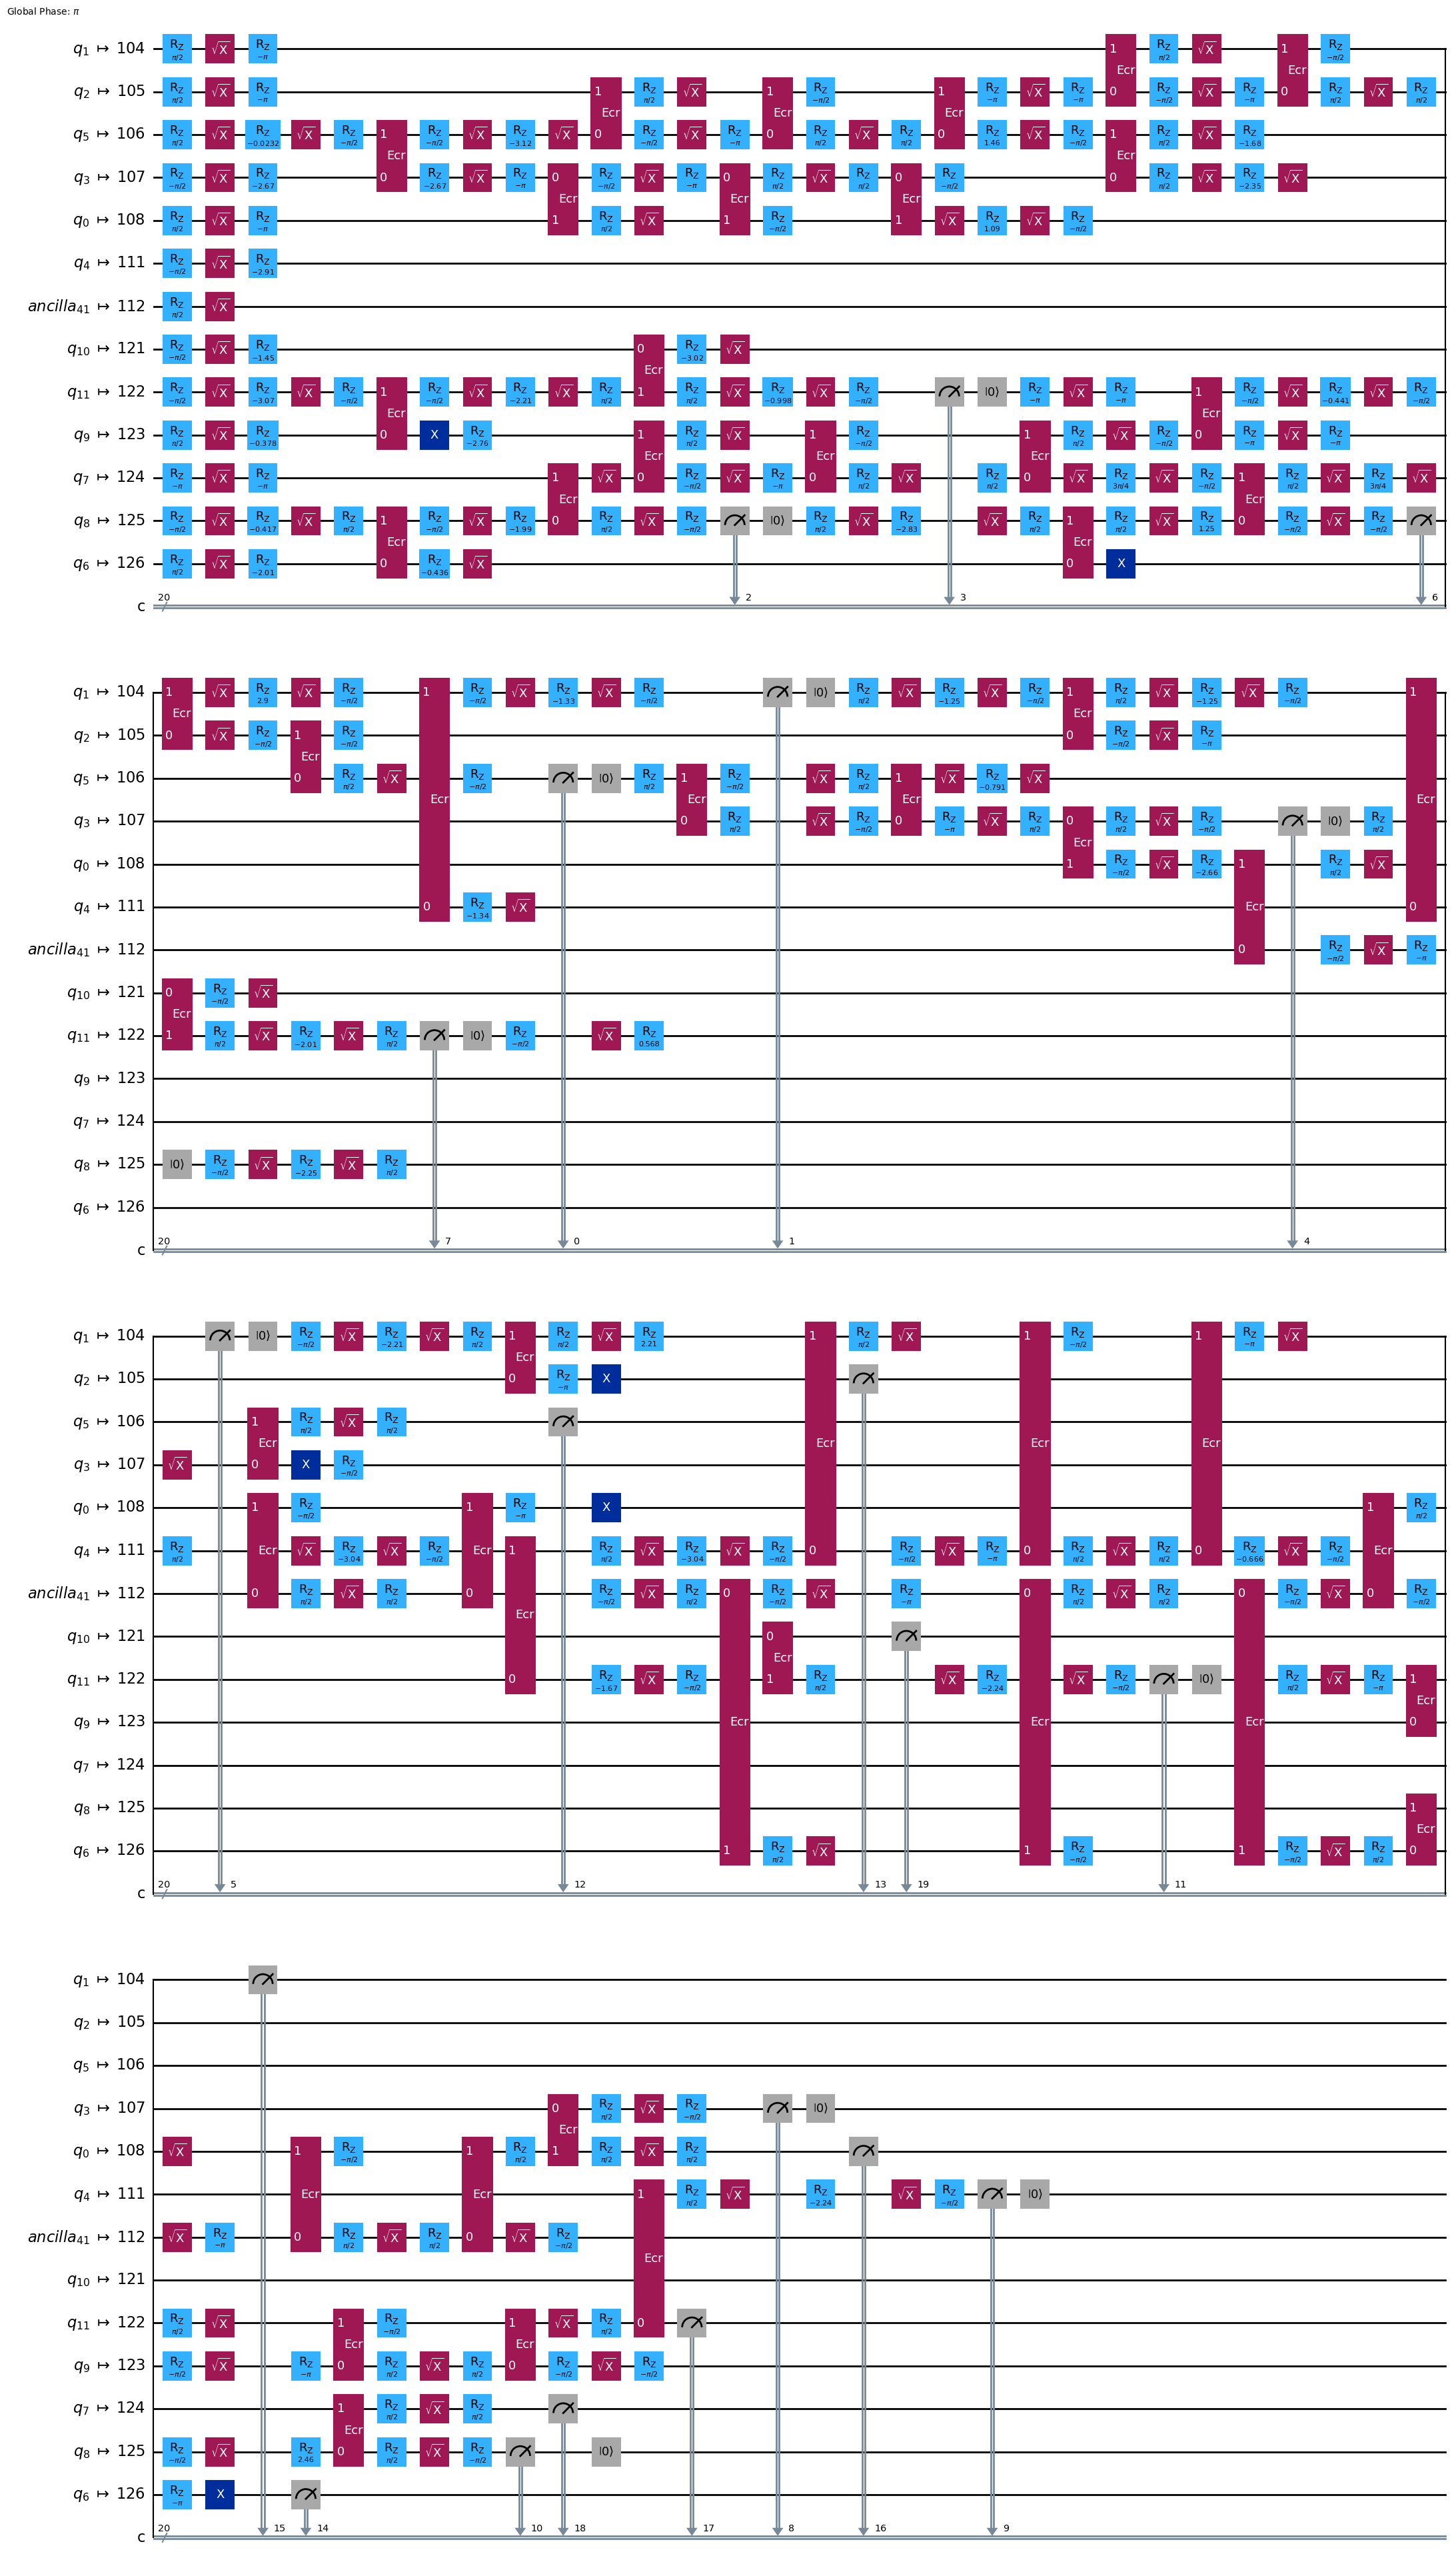

In [185]:
print(tqc.count_ops())
tqc.draw("mpl", idle_wires=False, fold=30)

OrderedDict({'rz': 288, 'sx': 156, 'ecr': 69, 'measure': 24, 'reset': 16, 'x': 11, 'if_else': 4})


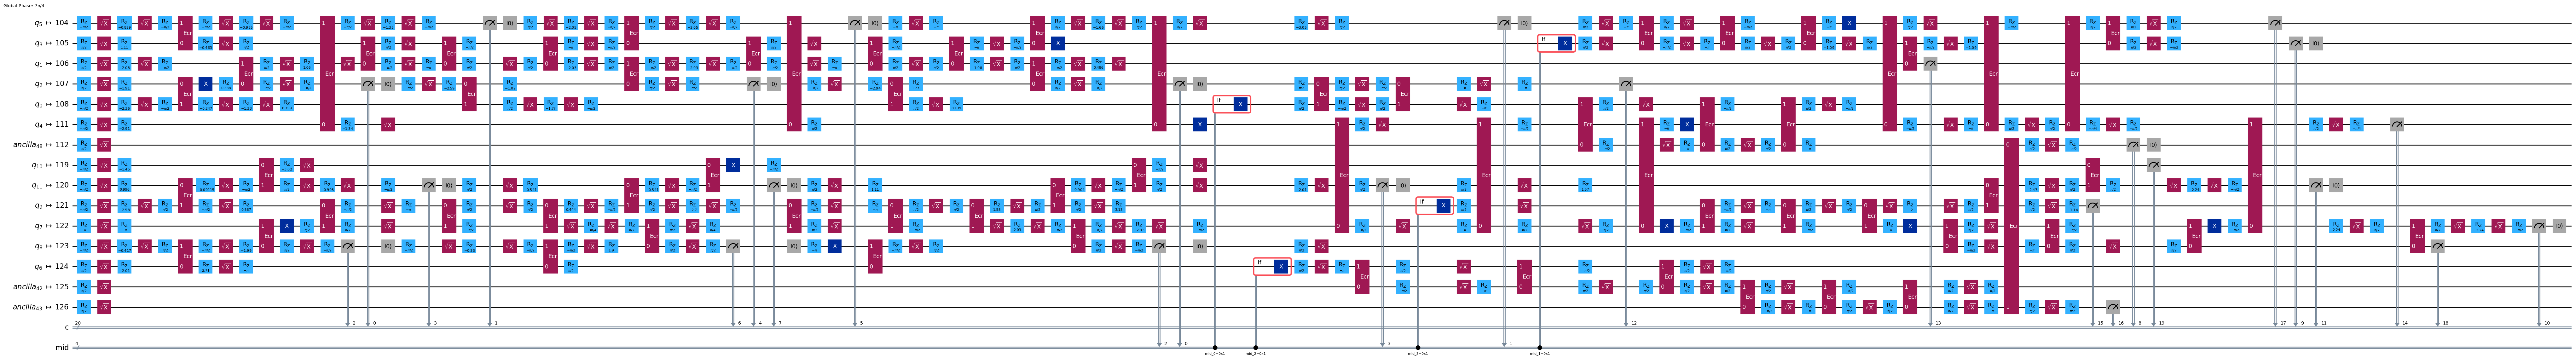

In [183]:
print(tqc_new.count_ops())
tqc_new.draw("mpl", idle_wires=False, fold=-1)

In [190]:
tqc_new = pm.run(new_circuit)


### Run on noiseless simulator

In [176]:
result = sim_ideal.run(tqc_new, shots = shots).result()
count_ideal = result.get_counts()
creg_counts = {}
for key, value in count_ideal.items():
    key = key.replace(" ", "")  # remove spaces, just in case
    creg_part = key[-20:]  # slice last 20 bits (adjust based on your circuit)
    creg_counts[creg_part] = creg_counts.get(creg_part, 0) + value

n = 3
lstate = "X"
get_logical_error_on_accepted_states(n, lstate, creg_counts)

(3000, 0, 0, 1.0, 0.16246100099670002, -0.004101355996681377)

### Run on noisy simulator from backend

The problem here the correction will add a lot of swaps, which not ideal. In this case, it is better to use all to all connection

In [188]:
result = sim_noisy.run(tqc_new, shots = shots, seed_simulator=12345).result()
count_noisy = result.get_counts()
creg_counts = {}
for key, value in count_noisy.items():
    key = key.replace(" ", "")  # remove spaces, just in case
    creg_part = key[-20:]  # slice last 20 bits (adjust based on your circuit)
    creg_counts[creg_part] = creg_counts.get(creg_part, 0) + value
get_logical_error_on_accepted_states(n, lstate, creg_counts)

(1924, 215, 322, 0.8882536382536382, 0.13423621399851982, 0.04441811400465667)

In [189]:
result = sim_noisy.run(tqc, shots = shots, seed_simulator=12345).result()
count_noisy = result.get_counts()
get_logical_error_on_accepted_states(n, lstate, count_noisy)

(1919, 194, 313, 0.8989056800416884, 0.14030992499829154, 0.04348776200276916)

## Run on noisy simulator 

In [227]:
# Example error probabilities
p_reset = 0.03
p_meas = 0.1
p_gate1 = 0.05

# QuantumError objects
error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
error_gate2 = error_gate1.tensor(error_gate1)

# Add errors to noise model
noise_bit_flip = NoiseModel()
noise_bit_flip.add_all_qubit_quantum_error(error_reset, "reset")
noise_bit_flip.add_all_qubit_quantum_error(error_meas, "measure")
noise_bit_flip.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
noise_bit_flip.add_all_qubit_quantum_error(error_gate2, ["cx"])

print(noise_bit_flip)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u1', 'reset', 'cx', 'u3', 'measure', 'u2']
  All-qubits errors: ['reset', 'measure', 'u1', 'u2', 'u3', 'cx']


In [ ]:
# Create noisy simulator backend
sim_noise = AerSimulator(noise_model=noise_bit_flip)

# Transpile circuit for noisy basis gates
circ_tnoise = transpile(circ, sim_noise)

# Run and get counts
result_bit_flip = sim_noise.run(circ_tnoise).result()
counts_bit_flip = result_bit_flip.get_counts(0)

# Plot noisy output
plot_histogram(counts_bit_flip)

# Polar Code - Stim

Problem with Stim:

- the normal simulator: it doesn't support the mid-circuit measurements and the feed forward action, but with noise
- the tableau simulator: it support the mid-circuit measurements and the feed forward action, but without noise

## Normal

In [191]:
polar_n3_x = polar_code_p2(3, False, "x", False)
# polar_n3_x.draw("mpl", fold=-1)

n = 3 , b = 010 (2) , i = 3


In [192]:
polar_n4_z = polar_code_p2(4, False, "z", False)
# polar_n4_z.draw("mpl", fold=-1)

n = 4 , b = 0110 (6) , i = 7


In [193]:
qasm_str = dumps(polar_n3_x)

#qasm_str = dumps(polar_n4_z)

In [195]:
import cirq
import stim
from cirq.contrib.qasm_import import circuit_from_qasm
import stimcirq

cirq_circuit = circuit_from_qasm(qasm_str)

stim_circuit = stimcirq.cirq_circuit_to_stim_circuit(cirq_circuit)

# n3_x
stim_circuit.append("M", [0,1,3,4,6,7,9,10])

# n4_z
#stim_circuit.append("M", [0,1,3,4,6,7,9,10,12,13,15,16,18,19,21,22])

In [213]:
#print(dir(stim_circuit))

In [214]:
stim_circuit.num_qubits

12

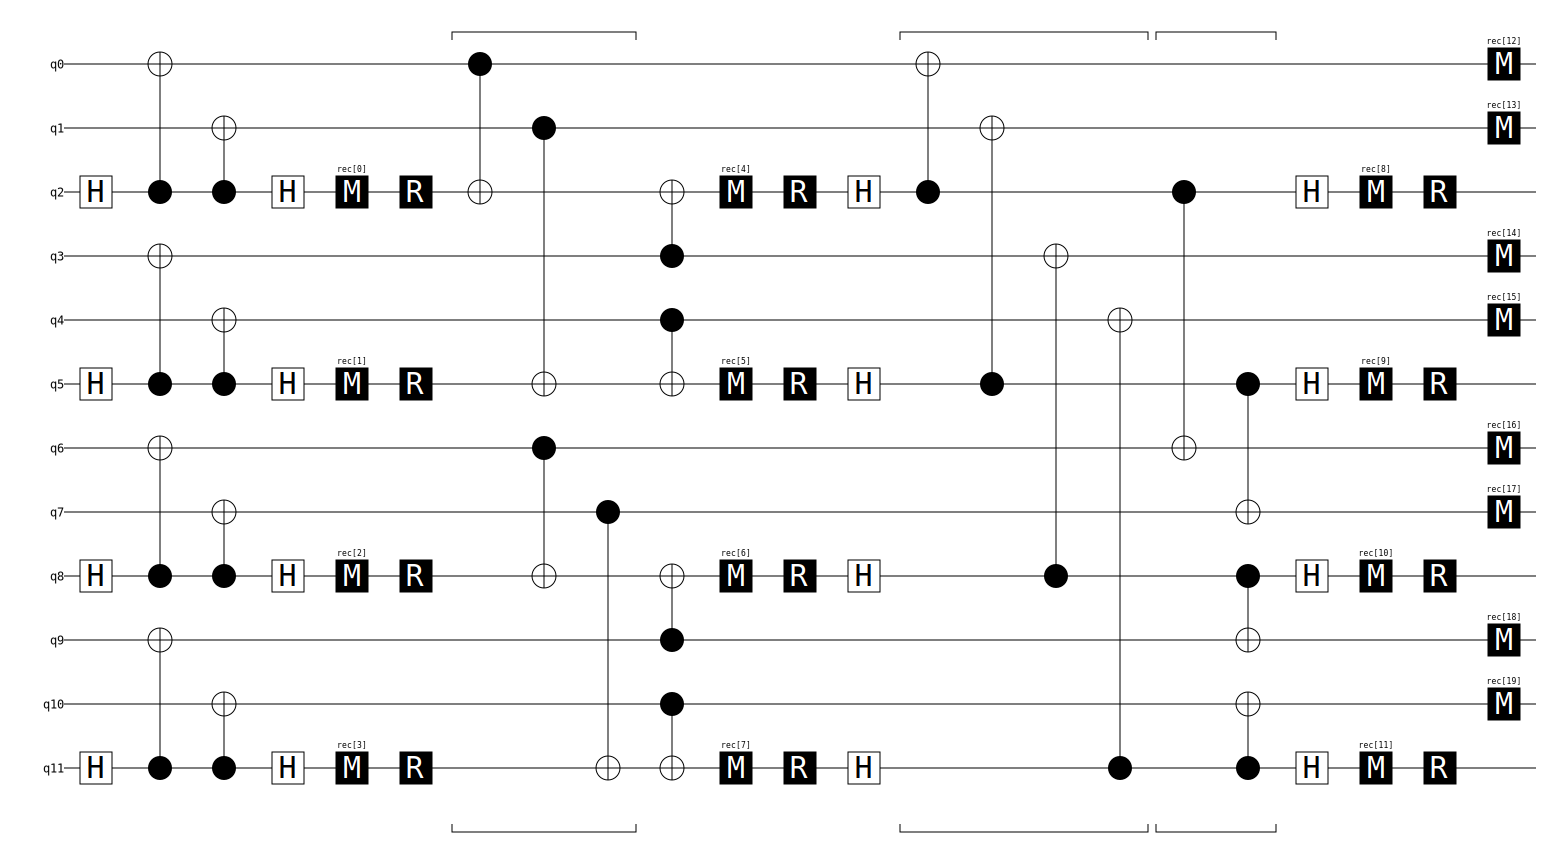

In [203]:
diagram = stim_circuit.diagram("timeline-svg")
diagram

In [215]:
with open('diagram_n3.svg', 'w') as f:
    print(diagram, file=f)
    

### Noiseless

In [22]:
# manual polar_n3_x

circuit = stim.Circuit()

# First, the circuit will initialize a Bell pair.
circuit.append("R", range(0,12))

circuit.append("H", [2,5,8,11])
circuit.append("CNOT", [2, 0, 5, 3, 8, 6, 11, 9])
circuit.append("CNOT", [2, 1, 5, 4, 8, 7, 11, 10])
circuit.append("H", [2,5,8,11])
circuit.append("M", [2,5,8,11])

circuit.append("R", [2,5,8,11])
circuit.append("CNOT", [0, 2, 1, 5, 6, 8, 7, 11])
circuit.append("CNOT", [3, 2, 4, 5, 9, 8, 10, 11])
circuit.append("M", [2,5,8,11])

circuit.append("R", [2,5,8,11])
circuit.append("H", [2,5,8,11])
circuit.append("CNOT", [2, 0, 5, 1, 8, 3, 11, 4])
circuit.append("CNOT", [2, 6, 5, 7, 8, 9, 11, 10])
circuit.append("H", [2,5,8,11])
circuit.append("M", [2,5,8,11])

circuit.append("H", [0,1,3,4,6,7,9,10])
circuit.append("M", [0,1,3,4,6,7,9,10])


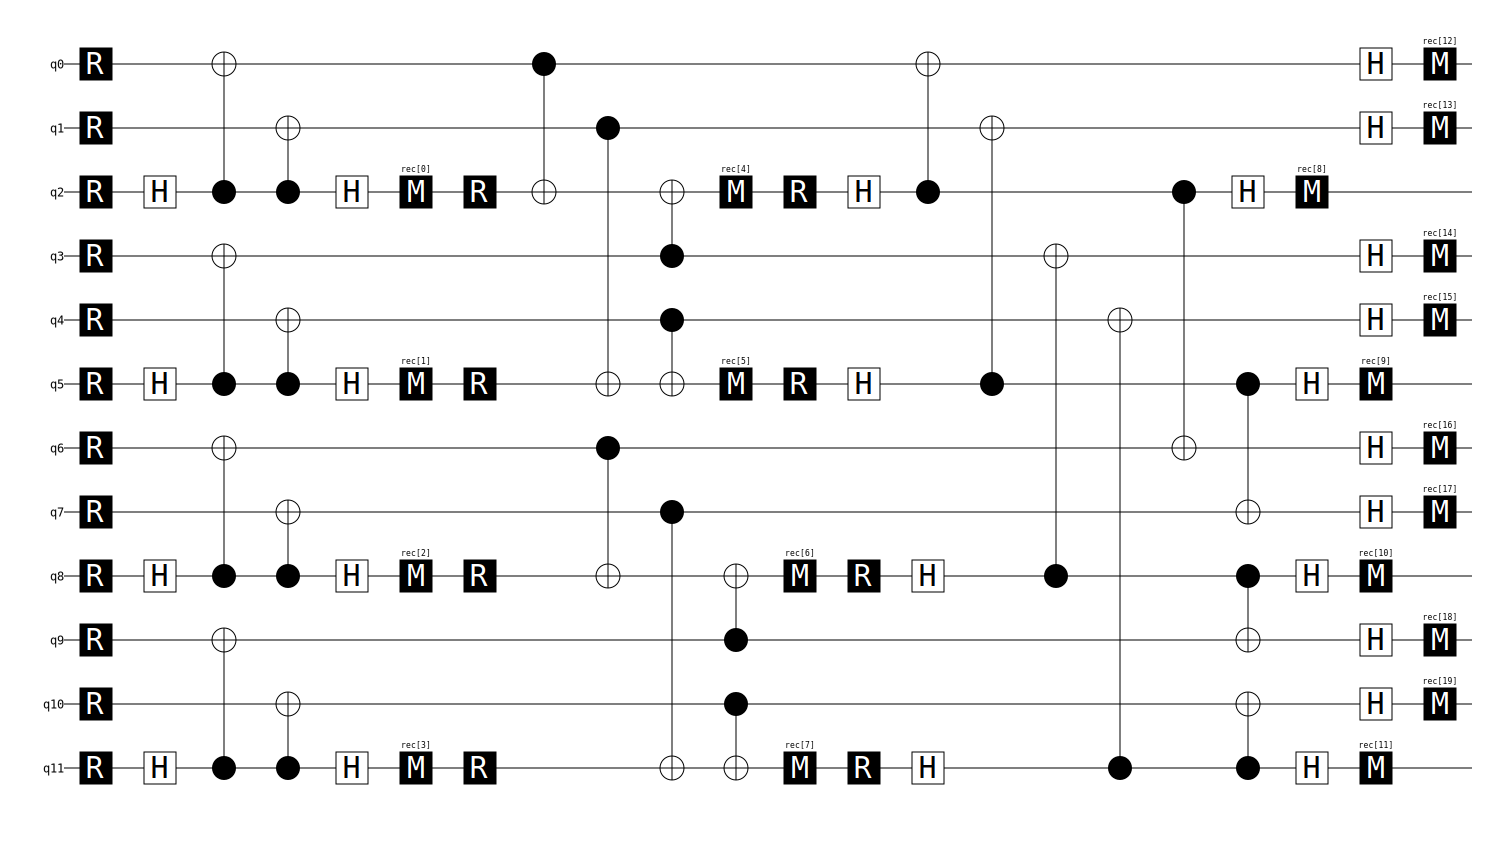

In [23]:
circuit.diagram("timeline-svg")

In [25]:
sampler = stim_circuit.compile_sampler()
results = sampler.sample(shots=10000)

res_bit_string = {}
for res in results:
    bit_string = ""
    for i in res:
        if i:
            bit_string = "1" + bit_string 
        else:
            bit_string = "0" + bit_string

    if bit_string in res_bit_string:
        res_bit_string[bit_string] = res_bit_string[bit_string] + 1
    else:
        res_bit_string[bit_string] = 1




In [26]:
n = 4
lstate = "Z"
get_logical_error_on_accepted_states(n, lstate, res_bit_string)

(10000, 0, 0, 1.0, 1.1109039180009859, 0.3054378500019084)

#### Lets analyze layer by layer

In [ ]:
tmp = stim.Circuit()

# First, the circuit will initialize a Bell pair.
tmp.append("R", range(0,12))
tmp.append("TICK")
tmp.append("H", [2,5,8,11])
tmp.append("TICK")
tmp.append("CNOT", [2, 0, 5, 3, 8, 6, 11, 9])
tmp.append("TICK")
tmp.append("CNOT", [2, 1, 5, 4, 8, 7, 11, 10])
tmp.append("TICK")
tmp.append("H", [2,5,8,11])
tmp.append("TICK")
tmp.append("M", [2,5,8,11])

#tmp.append("R", [2,5,8,11])
#tmp.append("TICK")
#tmp.append("CNOT", [0, 2, 1, 5, 6, 8, 7, 11])
#tmp.append("TICK")
#tmp.append("CNOT", [3, 2, 4, 5, 9, 8, 10, 11])
#tmp.append("TICK")
#tmp.append("M", [2,5,8,11])

#tmp.append("R", [2,5,8,11])
#tmp.append("TICK")
#tmp.append("H", [2,5,8,11])
#tmp.append("TICK")
#tmp.append("CNOT", [2, 0, 5, 1, 8, 3, 11, 4])
#tmp.append("TICK")
#tmp.append("CNOT", [2, 6, 5, 7, 8, 9, 11, 10])
#tmp.append("TICK")
#tmp.append("H", [2,5,8,11])
#tmp.append("TICK")
#tmp.append("M", [2,5,8,11])

#tmp.append("DETECTOR", [stim.target_rec(-12), stim.target_rec(-8), stim.target_rec(-4)])
#tmp.append("DETECTOR", [stim.target_rec(-11), stim.target_rec(-7), stim.target_rec(-3)])
#tmp.append("DETECTOR", [stim.target_rec(-10), stim.target_rec(-6), stim.target_rec(-2)])
#tmp.append("DETECTOR", [stim.target_rec(-9), stim.target_rec(-5), stim.target_rec(-1)])

#tmp.append("DETECTOR", [stim.target_rec(-12), stim.target_rec(-4)])
#tmp.append("DETECTOR", [stim.target_rec(-11), stim.target_rec(-3)])
#tmp.append("DETECTOR", [stim.target_rec(-10), stim.target_rec(-2)])
#tmp.append("DETECTOR", [stim.target_rec(-9) , stim.target_rec(-1)])

#tmp.append("H", [0,1,3,4,6,7,9,10])
#tmp.append("M", [0,1,3,4,6,7,9,10])

tmp

### Noisy

In [205]:
noisy_circuit = stim.Circuit()

for ins in stim_circuit:
    used_qubits = []
    idle_qubits = []

    if ins.name != "M":
        noisy_circuit.append(ins)
    
    # TICK doesn't have an error
    if ins.name == "TICK":
        continue
    
    if ins.name == "H":
        noisy_circuit.append("X_ERROR", ins.targets_copy(), 0.001)
    elif ins.name == "CX":
        noisy_circuit.append("DEPOLARIZE2", ins.targets_copy(), 0.001)
    elif ins.name == "M":
        noisy_circuit.append("X_ERROR", ins.targets_copy(), 0.001)

    for qt in ins.targets_copy():
        used_qubits.append(qt.value)

    for i in range(stim_circuit.num_qubits):
        if i not in used_qubits:
            idle_qubits.append(stim.GateTarget(i))

    if ins.name == "M":
        noisy_circuit.append(ins)
    
    if len(idle_qubits) > 1:
        noisy_circuit.append("DEPOLARIZE1", idle_qubits, 0.001)    

#noisy_circuit

In [226]:
noisy_circuit.to_tableau(ignore_noise=True, ignore_measurement=True, ignore_reset=True)

stim.Tableau.from_conjugated_generators(
    xs=[
        stim.PauliString("+X_X_________"),
        stim.PauliString("+_X___X______"),
        stim.PauliString("+__X_________"),
        stim.PauliString("+__XX________"),
        stim.PauliString("+____XX______"),
        stim.PauliString("+_____X______"),
        stim.PauliString("+______X_X___"),
        stim.PauliString("+_______X___X"),
        stim.PauliString("+________X___"),
        stim.PauliString("+________XX__"),
        stim.PauliString("+__________XX"),
        stim.PauliString("+___________X"),
    ],
    zs=[
        stim.PauliString("+Z___________"),
        stim.PauliString("+_ZX__X______"),
        stim.PauliString("-ZXZZ_XX_X___"),
        stim.PauliString("+___Z_X__X___"),
        stim.PauliString("+____ZX_____X"),
        stim.PauliString("+_YXXYZ_X___X"),
        stim.PauliString("+__X___Z_X___"),
        stim.PauliString("+_____X_ZX___"),
        stim.PauliString("+__XX__YXZY_X"),
        stim.PauliString("+____

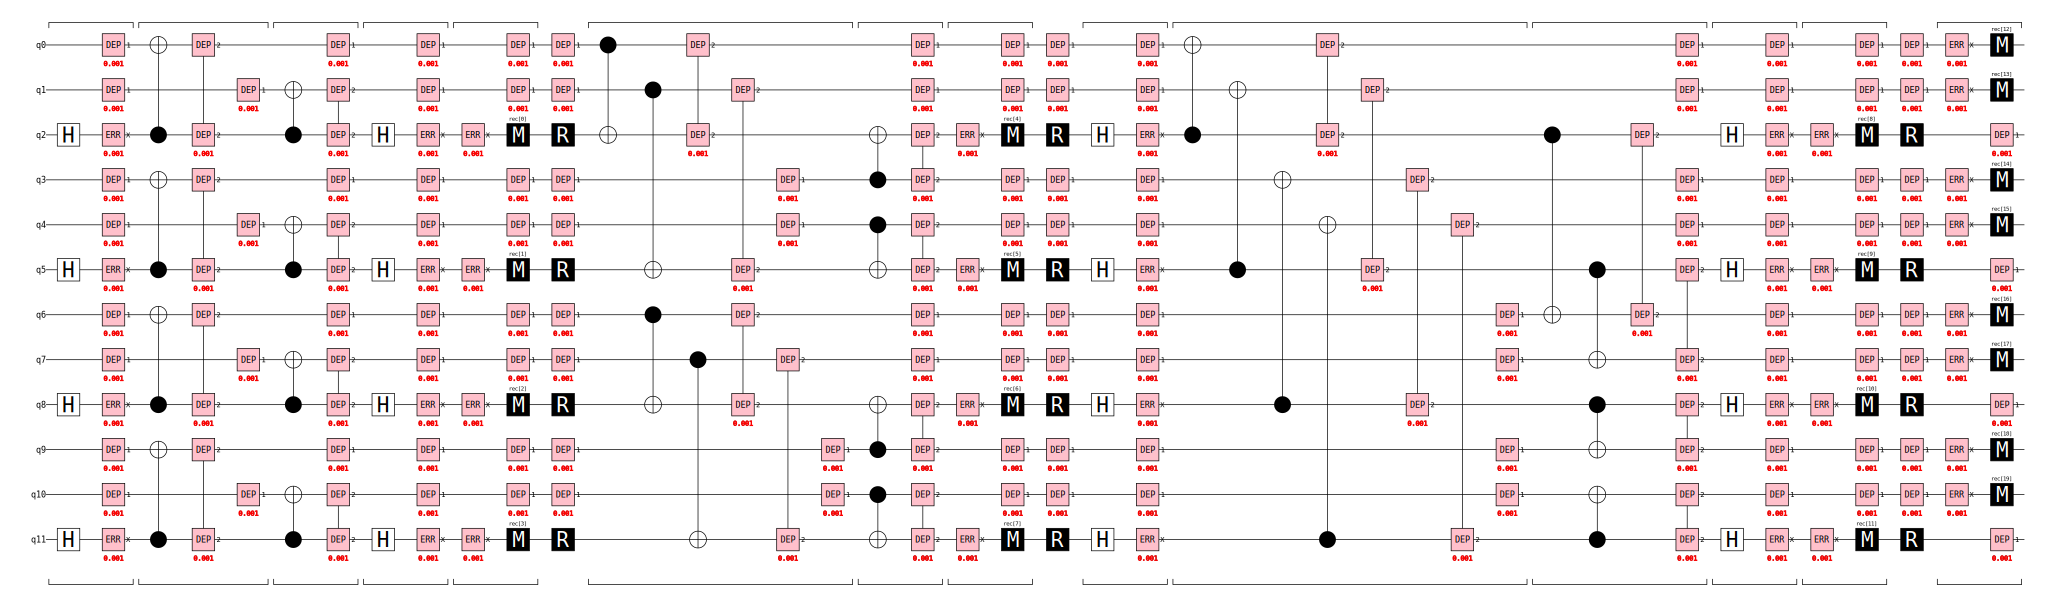

In [208]:
noisy_circuit.diagram("timeline-svg")

In [211]:
sampler = noisy_circuit.compile_sampler()
results = sampler.sample(shots=10000)

res_bit_string = {}
for res in results:
    bit_string = ""
    for i in res:
        if i:
            bit_string = "1" + bit_string 
        else:
            bit_string = "0" + bit_string

    if bit_string in res_bit_string:
        res_bit_string[bit_string] = res_bit_string[bit_string] + 1
    else:
        res_bit_string[bit_string] = 1

In [212]:
n = 3
lstate = "X"
get_logical_error_on_accepted_states(n, lstate, res_bit_string)

(9095, 3588, 6739, 0.605497526113249, 0.401650410000002, 0.11065365099784685)

## Proposal

In [218]:
dag = circuit_to_dag(polar_n3_x)

qreg = QuantumRegister(12, name="q")
creg = ClassicalRegister(20, name="c")
mid_measure = ClassicalRegister(4, name="mid")
polar_n3_x_corr = QuantumCircuit(qreg, creg, mid_measure)
for idx, layer in enumerate(dag.layers()):
    layer_as_circuit = dag_to_circuit(layer['graph'])
    polar_n3_x_corr = polar_n3_x_corr.compose(layer_as_circuit)

    if idx == 9:
        for m_idx, i in enumerate(range(0, 11, 3)):
            controls = [i, i+1]
            target = i + 2
            measure = mid_measure[m_idx]
        
            extract_z_syndrome(polar_n3_x_corr, target, controls, measure)
            


/tmp/ipykernel_13549/777707607.py:8: DeprecationWarning: The property ``qiskit.dagcircuit.dagcircuit.DAGCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  layer_as_circuit = dag_to_circuit(layer['graph'])
/tmp/ipykernel_13549/777707607.py:8: DeprecationWarning: The property ``qiskit.dagcircuit.dagcircuit.DAGCircuit.unit`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  layer_as_circuit = dag_to_circuit(layer['graph'])


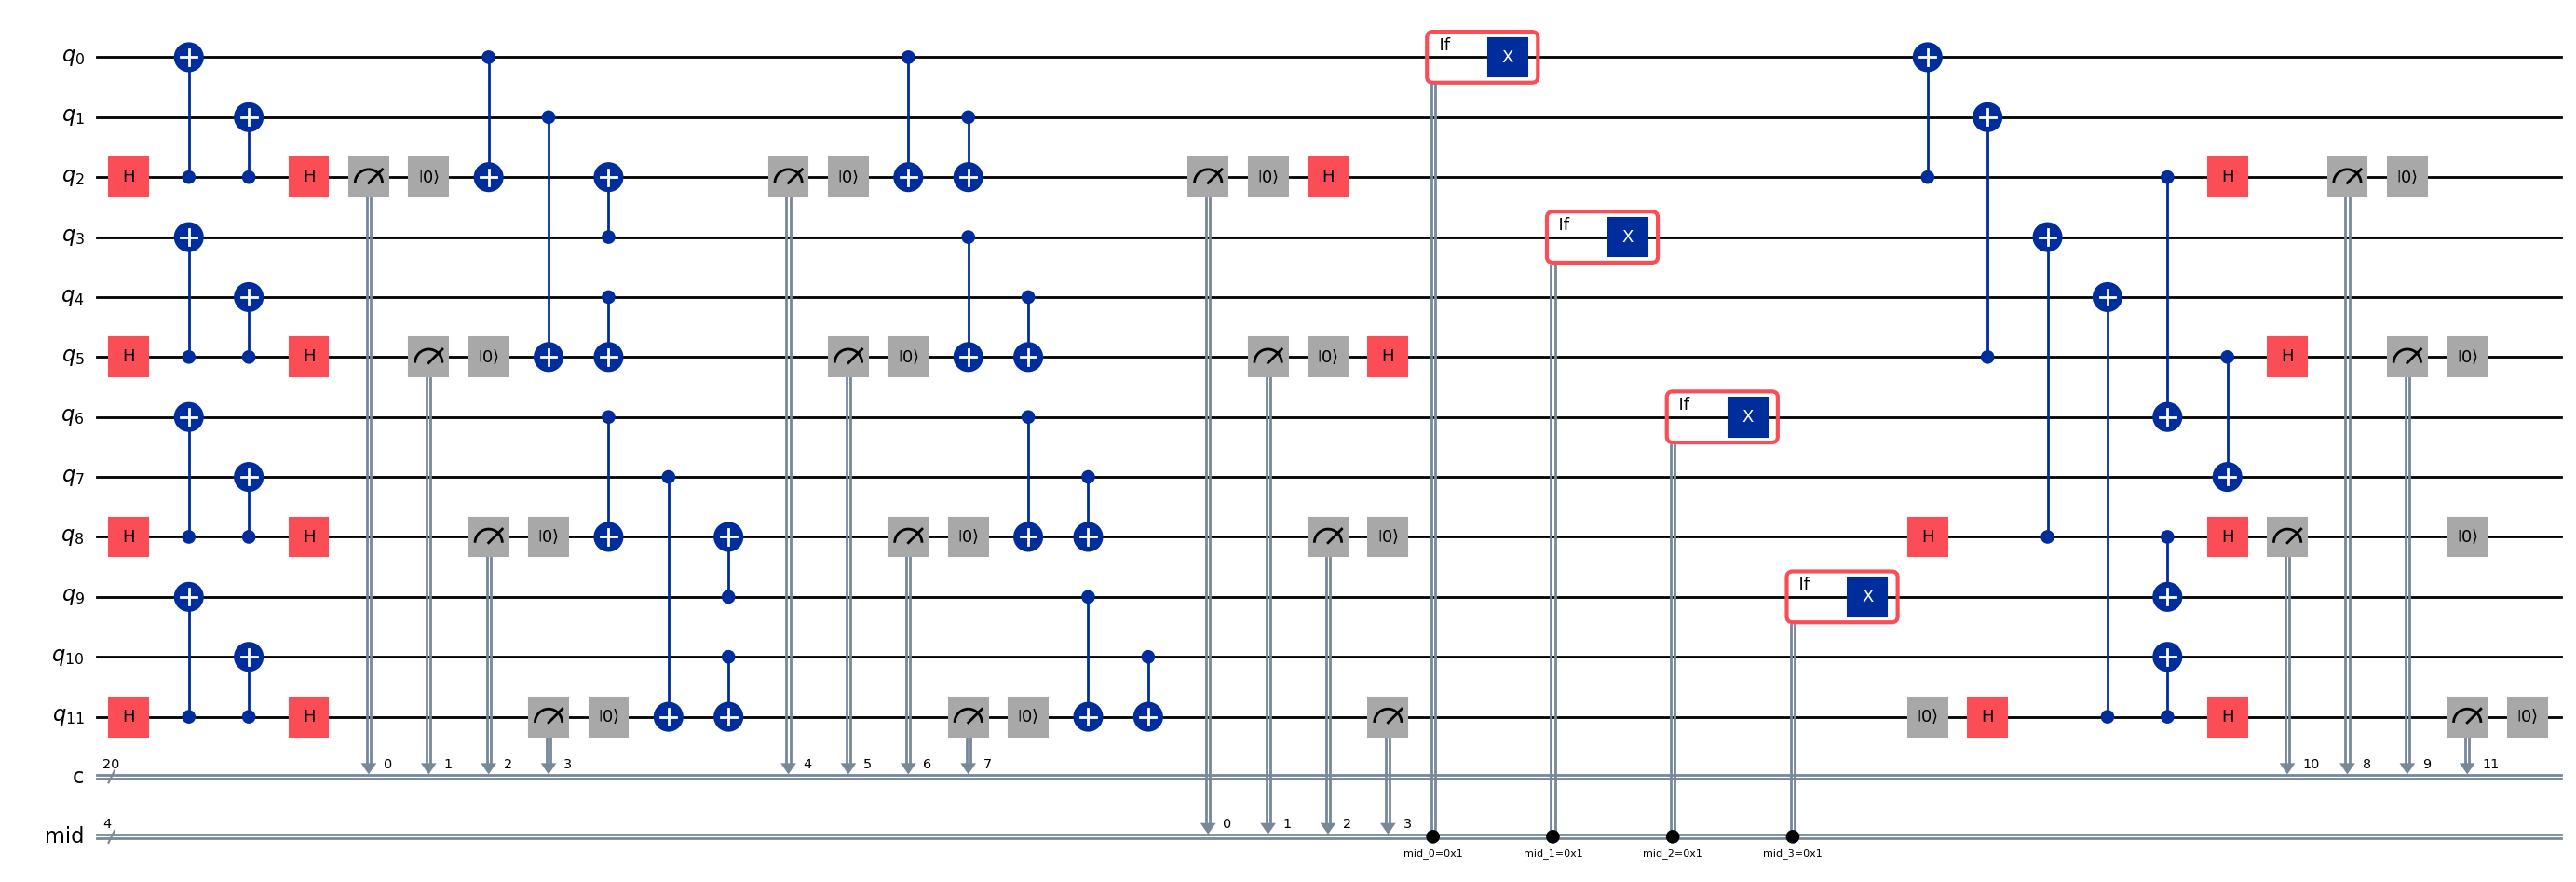

In [220]:
polar_n3_x_corr.draw("mpl", fold=-1)

In [221]:
qasm_str = dumps(polar_n3_x_corr)

QASM2ExportError: "OpenQASM 2 cannot represent 'if_else', which acts on 1 classical bits."